In [1]:
import os
import sys
import platform
import datetime
from datetime import timezone
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
# from sklearn.externals import joblib  # If using scikit-learn version < 0.24
from joblib import dump  # If using scikit-learn version >= 0.24
import pathlib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
    
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasRegressor

In [2]:
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Windows-10-10.0.19045-SP0
Tensor Flow Version: 2.15.0

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Pandas 2.0.2
Scikit-Learn 1.3.2
GPU is NOT AVAILABLE


In [3]:
# Funkcja pomocnicza
def plot_results(history):
    
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [4]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

In [5]:
# read data
merged_data = pd.read_csv('merged_data.csv', index_col='time')

In [6]:
# show read data
merged_data.head()

,total load actual,price actual,total_generation,temp,temp_min,temp_max,pressure,humidity,wind_speed,weather_main_clear,...,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,-0.735010,0.519210,-0.101986,-2.230399,-2.129082,-2.263250,0.382609,0.63,0.055556,True,...,-0.258819,0.965926,0.974928,-0.222521,0.207912,0.978148,-0.5,0.866025,-0.094537,-0.995521
2015-01-01 00:00:00+00:00,-0.953921,0.484673,-0.205237,-2.230399,-2.129082,-2.263250,0.382609,0.63,0.055556,True,...,0.000000,1.000000,0.433884,-0.900969,0.207912,0.978148,0.0,1.000000,-0.111659,-0.993747
2015-01-01 01:00:00+00:00,-1.313608,0.453660,-0.448936,-2.352877,-2.253411,-2.381298,0.382609,0.64,0.055556,True,...,0.258819,0.965926,0.433884,-0.900969,0.207912,0.978148,0.0,1.000000,-0.111659,-0.993747
2015-01-01 02:00:00+00:00,-1.629644,0.089967,-0.824024,-2.352877,-2.253411,-2.381298,0.382609,0.64,0.055556,True,...,0.500000,0.866025,0.433884,-0.900969,0.207912,0.978148,0.0,1.000000,-0.111659,-0.993747
2015-01-01 03:00:00+00:00,-1.852702,-0.141218,-0.967812,-2.352877,-2.253411,-2.381298,0.382609,0.64,0.055556,True,...,0.707107,0.707107,0.433884,-0.900969,0.207912,0.978148,0.0,1.000000,-0.111659,-0.993747


In [7]:
merged_data.isnull().sum(axis=0)

total load actual            0
price actual                 0
total_generation             0
temp                         0
temp_min                     0
temp_max                     0
pressure                     0
humidity                     0
wind_speed                   0
weather_main_clear           0
weather_main_clouds          0
weather_main_drizzle         0
weather_main_fog             0
weather_main_haze            0
weather_main_mist            0
weather_main_rain            0
weather_main_snow            0
weather_main_thunderstorm    0
hour_sin                     0
hour_cos                     0
day_of_week_sin              0
day_of_week_cos              0
day_of_month_sin             0
day_of_month_cos             0
month_sin                    0
month_cos                    0
day_of_year_sin              0
day_of_year_cos              0
dtype: int64

In [8]:
merged_data.isna().sum()[merged_data.isna().sum() > 0]

Series([], dtype: int64)

In [9]:
merged_data.columns[merged_data.any() == False]

Index([], dtype='object')

### Wizualizacja fragmentów szeregów czasowych dla price actual i total load actual

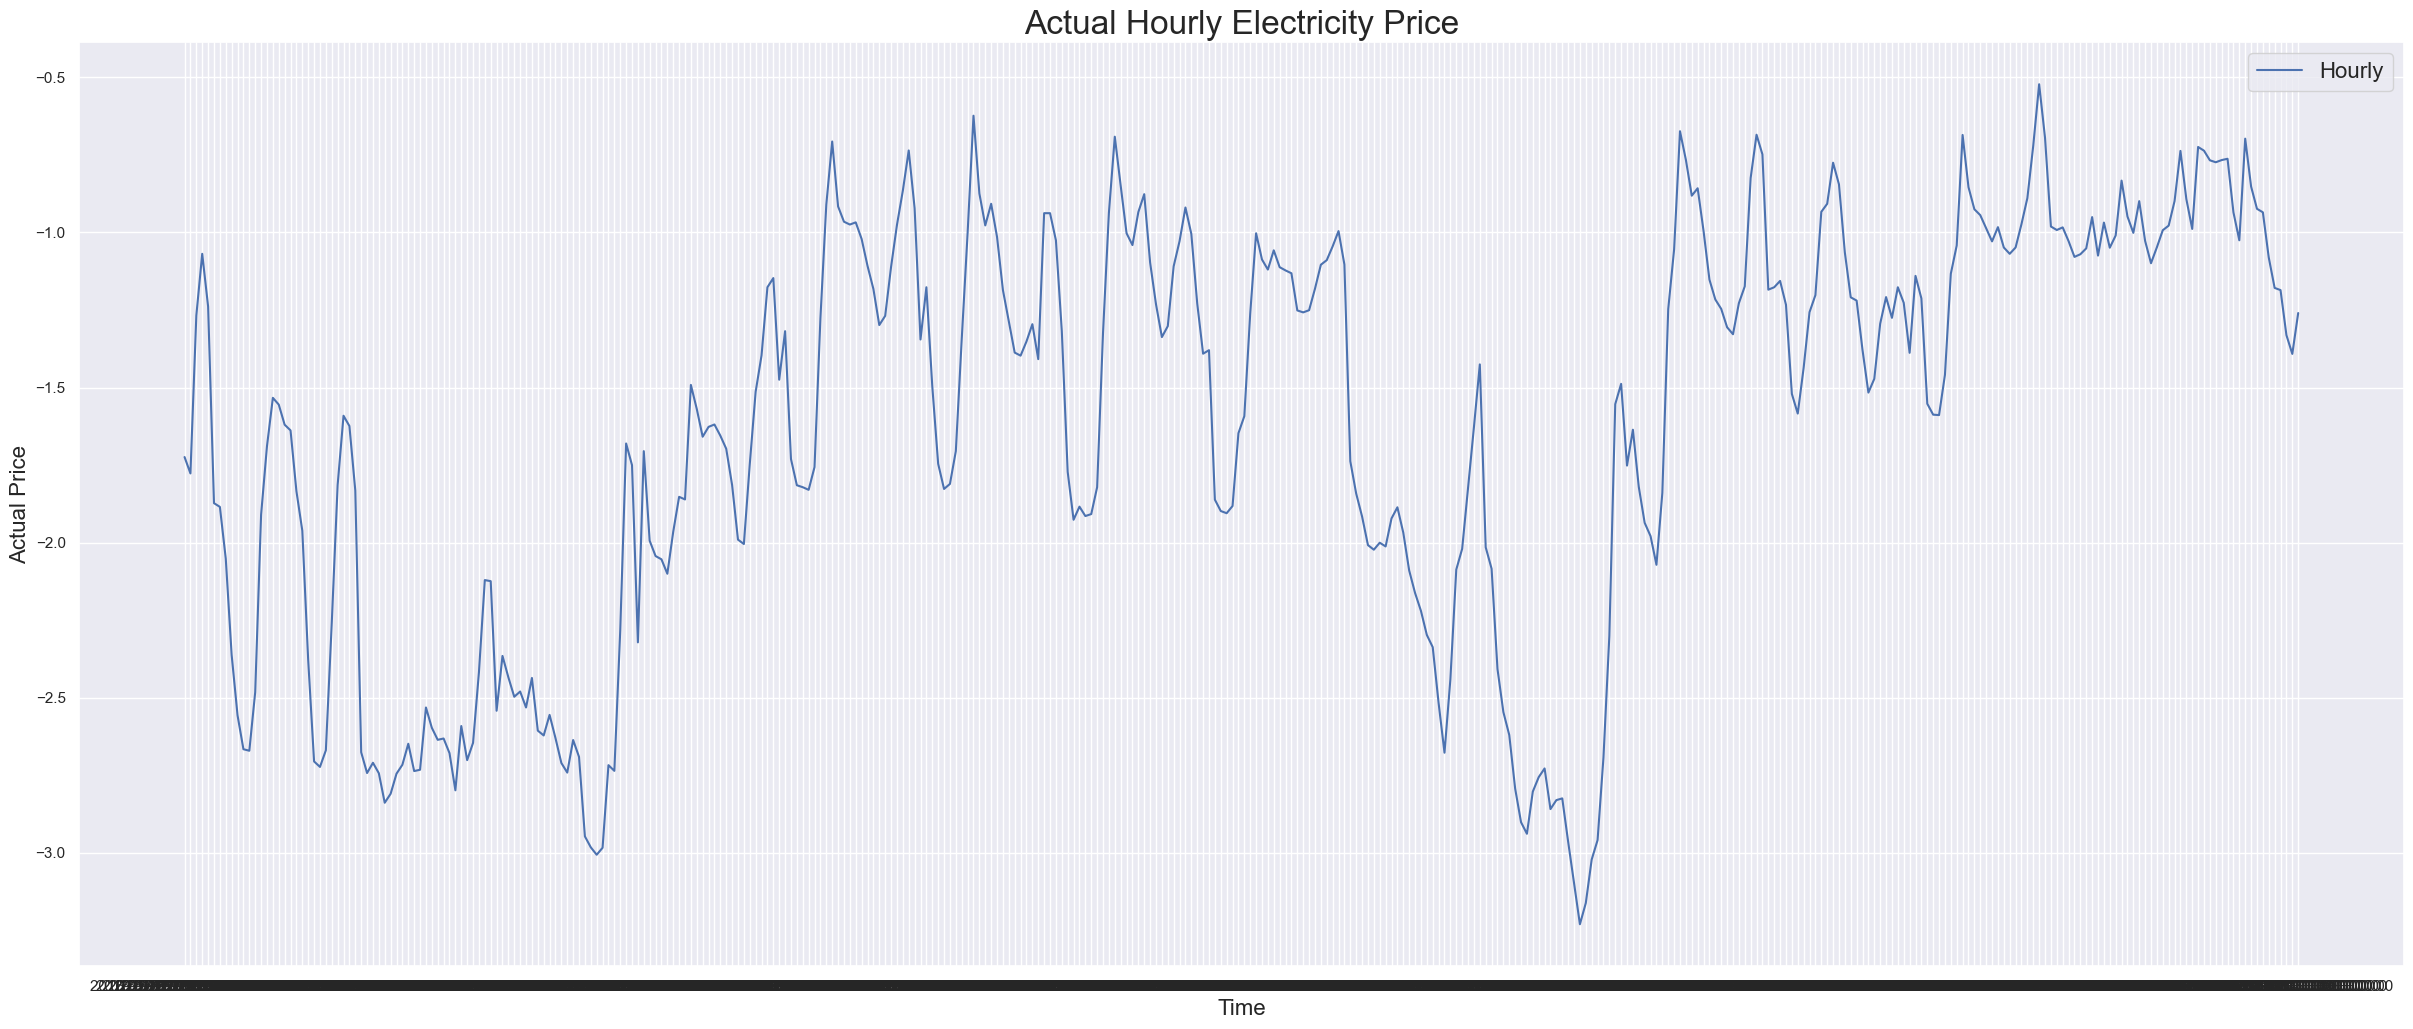

In [10]:
ax = plot_series(merged_data, 'price actual', label='Hourly', ylabel='Actual Price',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price')
plt.show()

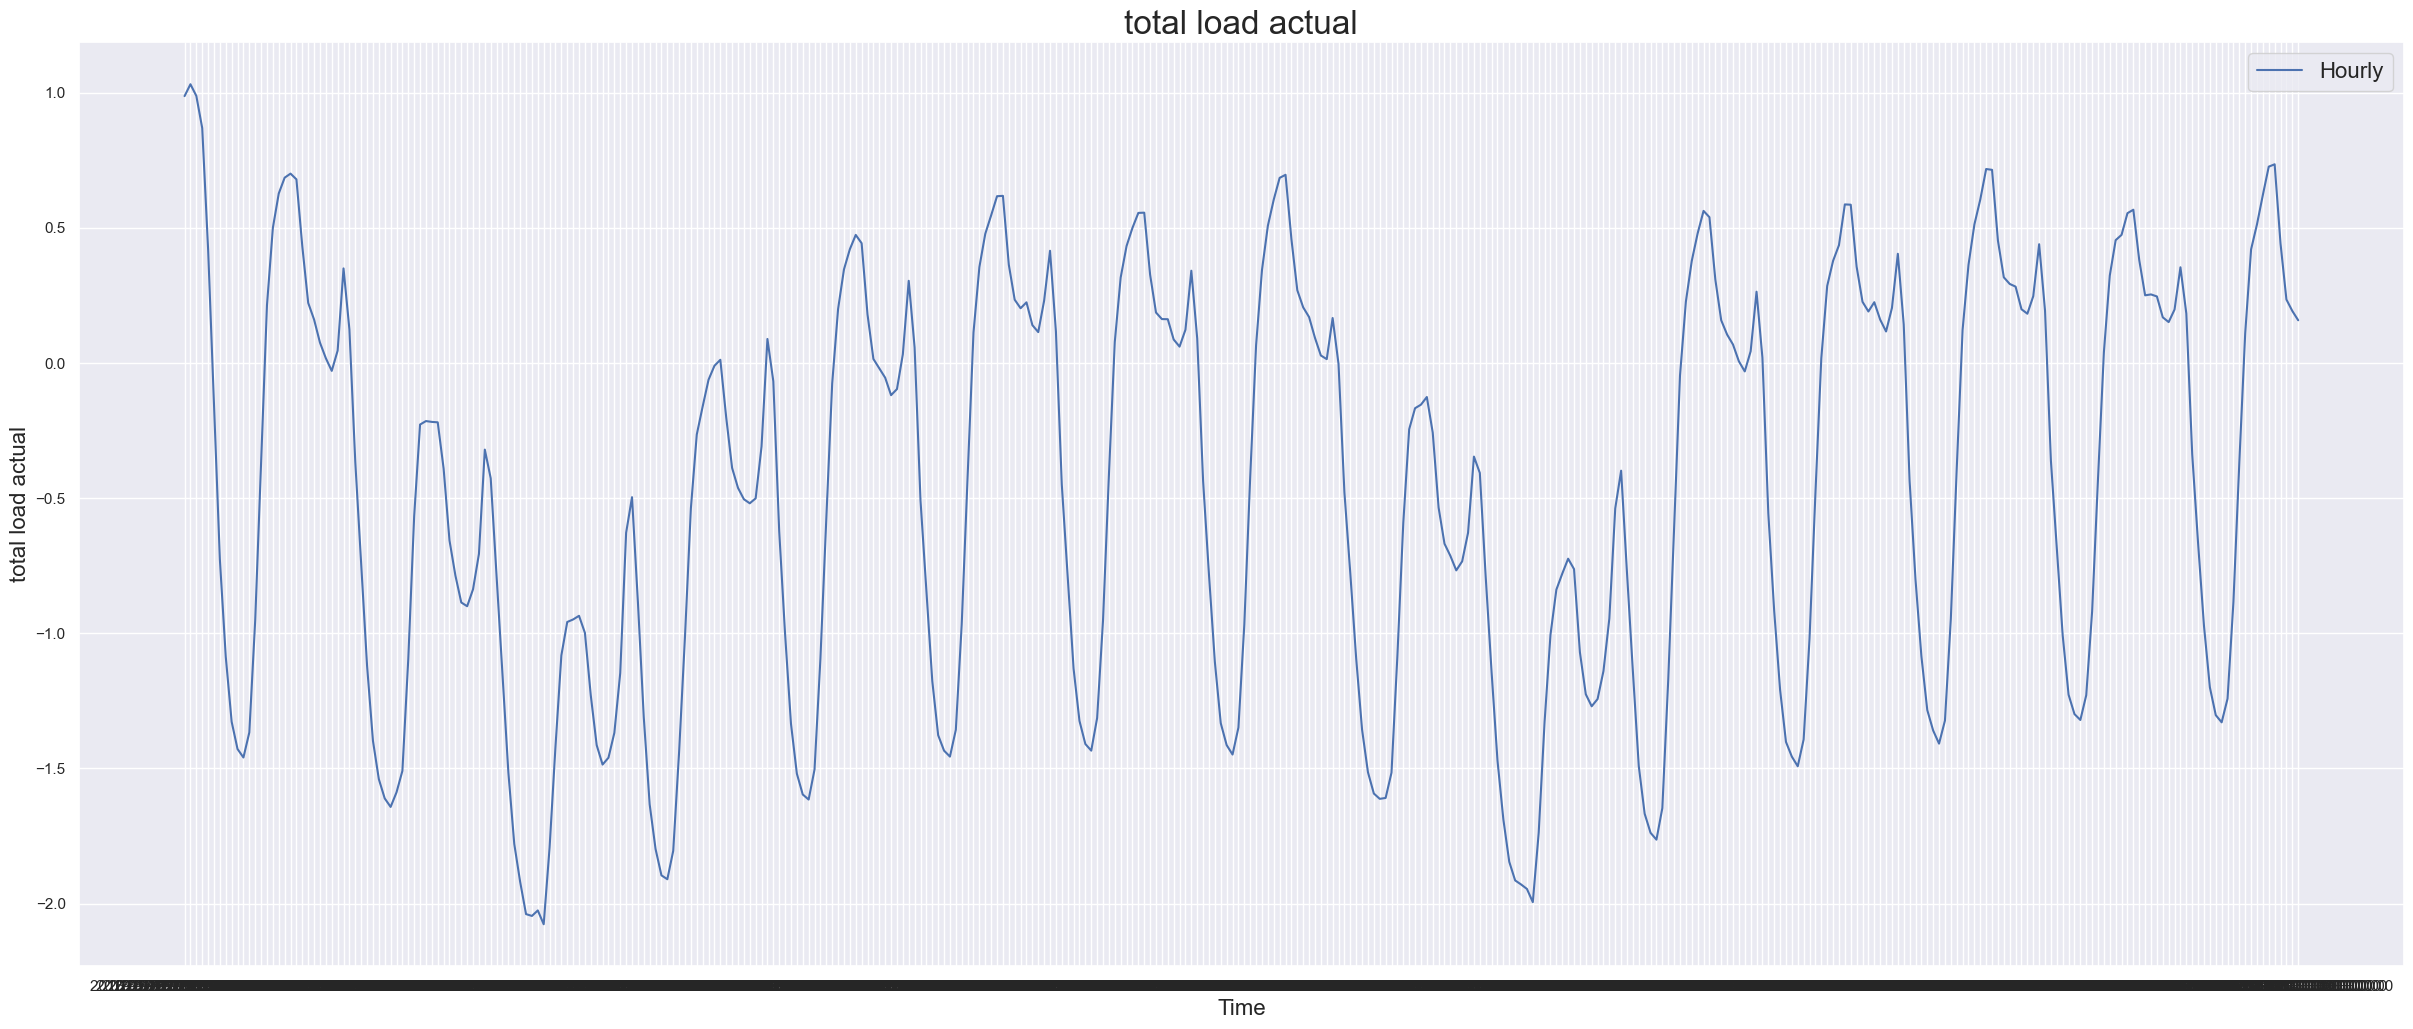

In [11]:
ax = plot_series(merged_data, 'total load actual', label='Hourly', ylabel='total load actual',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='total load actual')
plt.show()

---
---

In [12]:
# Check if data is ready for training
#
# columns are scaled (most standard distribution, some to [0, 1] range)
# removed redundant columns
# done time encoding
# one_hot encoding - weather_main
merged_data.dtypes

total load actual            float64
price actual                 float64
total_generation             float64
temp                         float64
temp_min                     float64
temp_max                     float64
pressure                     float64
humidity                     float64
wind_speed                   float64
weather_main_clear              bool
weather_main_clouds             bool
weather_main_drizzle            bool
weather_main_fog                bool
weather_main_haze               bool
weather_main_mist               bool
weather_main_rain               bool
weather_main_snow               bool
weather_main_thunderstorm       bool
hour_sin                     float64
hour_cos                     float64
day_of_week_sin              float64
day_of_week_cos              float64
day_of_month_sin             float64
day_of_month_cos             float64
month_sin                    float64
month_cos                    float64
day_of_year_sin              float64
d

---
---

In [14]:
def divide_data(data_all, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(data_all) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(data_all[indices])
        labels.append(target[i + target_size])
        

    return np.array(data), np.array(labels)

In [15]:
train_end_idx = int(36220 * 0.6)
val_end_idx = int(31200 * 0.8)
test_end_idx = 36220

In [16]:
X = merged_data[merged_data.columns.drop('total load actual')].values
y = merged_data['total load actual'].values
y = y.reshape(-1, 1)

In [17]:
X_train, y_train = divide_data(X, y,
                                    0, train_end_idx, 24, 
                                    0, step=1)
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [18]:
X_val, y_val = divide_data(X, y,
                                 train_end_idx, val_end_idx, 24, 
                                 0, step=1)
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')

In [19]:
X_test, y_test = divide_data(X, y,
                                   val_end_idx, test_end_idx, 24, 
                                   0, step=1)
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

---
---

In [20]:
# Define the base LSTM model
def create_lstm_model(units, dropout_rate, activation):
    loss = tf.keras.losses.MeanSquaredError()
    metric = [tf.keras.metrics.RootMeanSquaredError()]
    optimizer = tf.keras.optimizers.Adam()

    model = Sequential()
    model.add(LSTM(units, input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(180, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss=loss, metrics=metric, optimizer=optimizer)
    return model

In [24]:
# Define the parameter grid for the grid search
# lstm grid search (20-30 models)
param_grid = {
    "units": [50, 80, 100, 150],
    "dropout_rate": [0.1, 0.2, 0.3],
    "activation": ['relu', 'tanh'],
    "epochs": [80, 100, 120],
}

In [27]:
# use eraly stopping method
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

# Create the LSTM model
model = KerasRegressor(
    build_fn=create_lstm_model,
    dropout_rate=0.2,
    units=50,
    epochs=40,
    activation='relu',
    verbose=0
)


# Create the GridSearchCV object
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=3),
    verbose=1
)

In [28]:
# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])

Fitting 3 folds for each of 2 candidates, totalling 6 fits



C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initializ

In [35]:
# Save all trained models into a folder with training datetime as the folder name
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
folder_name = f"best_model_{now}"

os.makedirs(folder_name, exist_ok=True)

# Save all trained models
params = grid_result.best_estimator_.get_params()
units = str(params['units'])
dropout_rate = str(params['dropout_rate']).replace('.', '_')
epochs = str(params['epochs'])
activation = str(params['activation'])

model_name = f"lstm_model__units-{units}__dropout-{dropout_rate}__epochs-{epochs}__activation-{activation}.pkl"
# joblib.dump(grid_result.best_estimator_.model, model_name)  # Use .joblib suffix for scikit-learn < 0.24
dump(grid_result.best_estimator_.model, pathlib.Path(f"{folder_name}/{model_name}"))  # Use .joblib suffix for scikit-learn >= 0.24
print(f"Saved model as {model_name}")

Saved model as lstm_model__units-20__dropout-0_3__epochs-5__activation-tanh.pkl
